In [49]:
import zipfile
with zipfile.ZipFile('Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers.convolutional import Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dense, Flatten, Dropout

In [51]:
main_data = pd.read_csv('data_labels_mainData.csv')
extra_data = pd.read_csv('data_labels_extraData.csv')
# Specify the folder path where the images are located
folder_path = './patch_images/'

# Use glob to get a list of image file paths
image_paths = glob.glob(folder_path + '/*.png')  # Change the extension as per your image file types
df_paths = pd.DataFrame({'Image_Path': image_paths})


#merge the  datasets
# final_data_set = pd.concat([main_data, extra_data], ignore_index=True)

# train_data, test_data = train_test_split(main_data, test_size=0.2, random_state=0)
# train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=0)
# print("Train data: {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

In [52]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [53]:
cell_type_names = train_data['cellTypeName'].unique()
print("Cell Type Names:")
for name in cell_type_names:
    print(name)

Cell Type Names:
inflammatory
epithelial
fibroblast
others


In [54]:
df_paths['ImageName'] = df_paths['Image_Path'].apply(lambda x: os.path.basename(x))
train_data = pd.merge(main_data,df_paths, on='ImageName',how='inner')

In [55]:
train_data

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,Image_Path
0,22405,1,22405.png,fibroblast,0,0,./patch_images/22405.png
1,22406,1,22406.png,fibroblast,0,0,./patch_images/22406.png
2,22407,1,22407.png,fibroblast,0,0,./patch_images/22407.png
3,22408,1,22408.png,fibroblast,0,0,./patch_images/22408.png
4,22409,1,22409.png,fibroblast,0,0,./patch_images/22409.png
...,...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1,./patch_images/1625.png
9892,1626,60,1626.png,epithelial,2,1,./patch_images/1626.png
9893,1627,60,1627.png,epithelial,2,1,./patch_images/1627.png
9894,1628,60,1628.png,epithelial,2,1,./patch_images/1628.png


In [56]:
train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=0)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [57]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [58]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    # tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 2187)              0         
                                                                 
 dense_15 (Dense)            (None, 256)               560128    
                                                                 
 dense_16 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


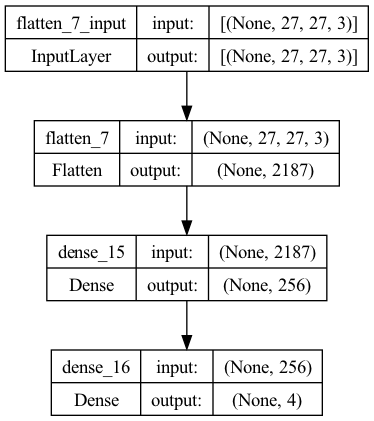

In [59]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [60]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [61]:
train_data['cellType'] = train_data['cellType'].astype(str)
val_data['cellType'] = val_data['cellType'].astype(str)
test_data['cellType'] = test_data['cellType'].astype(str)

In [62]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [63]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

/var/folders/6y/3ldd75pj46v0c4qyh730qx400000gn/T/ipykernel_3915/2779164914.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)
2023-05-15 22:00:13.747806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-15 22:00:17.612720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


In [64]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

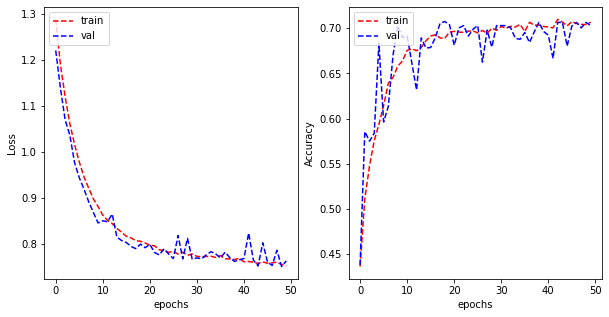

In [65]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [66]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


In [67]:
model.evaluate(test_generator)

  43/1980 [..............................] - ETA: 4s - loss: 0.8837 - categorical_accuracy: 0.7209    

2023-05-15 22:02:38.044244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1980/1980 [==============================] - 6s 3ms/step - loss: 0.7932 - categorical_accuracy: 0.6929


[0.7931978106498718, 0.6929292678833008]

In [68]:
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}

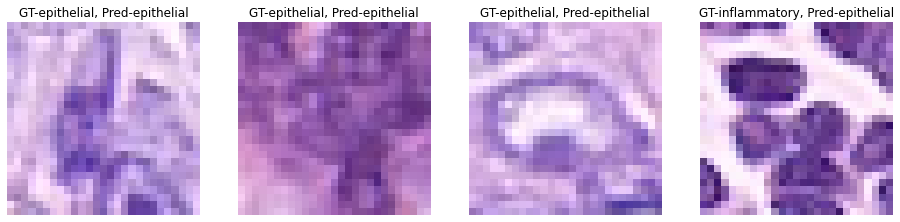

In [72]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,7))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

2023-05-15 22:02:44.669105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-15 22:02:50.100019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


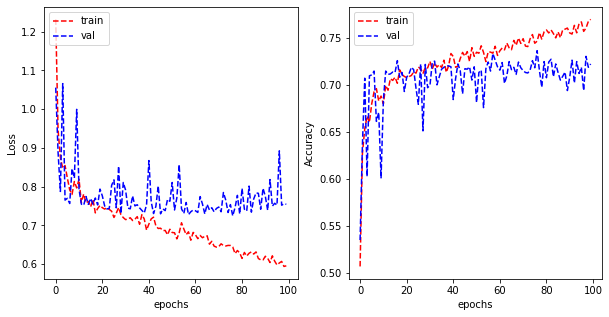

In [70]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Flatten(input_shape=INPUT_DIM),
#     tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
#     tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),  # Add an additional hidden layer
#     tf.keras.layers.Dense(OUTPUT_CLASSES)
# ])

# model.compile(optimizer='adam',  # Change the optimizer to Adam for better convergence
#               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])  # Use 'accuracy' instead of 'categorical_accuracy'

# history = model.fit(train_generator, validation_data=validation_generator, epochs=50, verbose=0)

# plot_learning_curve(history.history['loss'], history.history['val_loss'], 
#                     history.history['accuracy'], history.history['val_accuracy'], 
#                     metric_name='Accuracy')

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),  # Add an additional hidden layer
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

# Compile the model
model.compile(optimizer='adam',  # Change the optimizer to Adam for better convergence
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])  # Use 'accuracy' instead of 'categorical_accuracy'

# Train the model
history = model.fit(train_generator, validation_data=validation_generator, epochs=100, verbose=0)

# Plot the learning curves
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['accuracy'], history.history['val_accuracy'], 
                    metric_name='Accuracy')

In [71]:
model.evaluate(train_generator)

 11/186 [>.............................] - ETA: 1s - loss: 0.5176 - accuracy: 0.8068

2023-05-15 22:08:15.217071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


186/186 [==============================] - 2s 10ms/step - loss: 0.5549 - accuracy: 0.7824


[0.5549225807189941, 0.7823816537857056]